# Model with conditional interaction

In this example, we show global effects of a model with conditional interactions using PDP, ALE, and RHALE.
In particular, we:

1. show how to use `effector` to estimate the global effects using PDP, ALE, and RHALE
2. provide the analytical formulas for the global effects
3. test that (1) and (2) match

We will use the following model:

$$
f(x_1, x_2, x_3, x_4) = 
\begin{cases} 
-x_1^2 & \text{if } x_2 < 0 \text{ and } x_3 < 0, \\ 
x_1^2 & \text{if } x_2 < 0 \text{ and } x_3 \geq 0, \\ 
-x_1^4 & \text{if } x_2 \geq 0 \text{ and } x_3 < 0, \\ 
x_1^4 & \text{if } x_2 \geq 0 \text{ and } x_3 \geq 0 
\end{cases} 
+ e^{x_4}.
$$

Here, the features $x_1$, $x_2$, $x_3$, $x_4$ are independent and uniformly distributed in the interval $[-1, 1]$.

The model exhibits _interactions_ between $x_1$, $x_2$, and $x_3$, caused by the piecewise terms. 

This means the effect of $x_1$ on the output $y$ depends on the values of both $x_2$ and $x_3$, and vice versa. These interactions make it challenging to isolate the individual contributions of $x_1$, $x_2$, and $x_3$. Each global effect method has a different strategy to handle such multi-way interactions.

On the other hand, $x_4$ does not interact with any other feature, so its effect can be easily computed as $e^{x_4}$.

Below, we will see how methods like PDP, ALE, and RHALE handle these interactions and compute feature effects in this updated model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import effector

np.random.seed(21)

model = effector.models.ConditionalInteraction4Regions()
dataset = effector.datasets.IndependentUniform(dim=4, low=-1, high=1)
x = dataset.generate_data(1000)

/Users/dimitriskyriakopoulos/Documents/ath/Effector/Code/eff-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## PDP

### Effector

Let's see below the PDP effects for each feature, using `effector`.

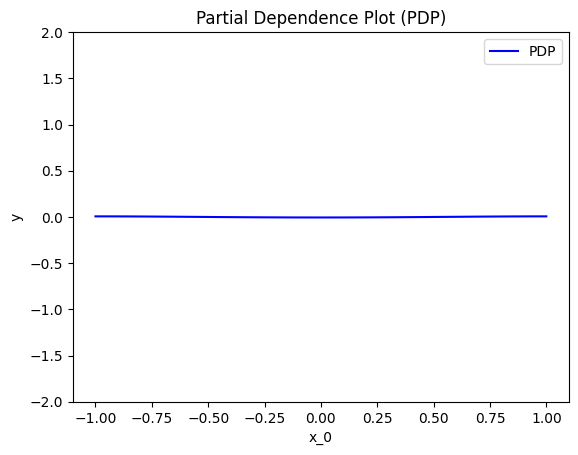

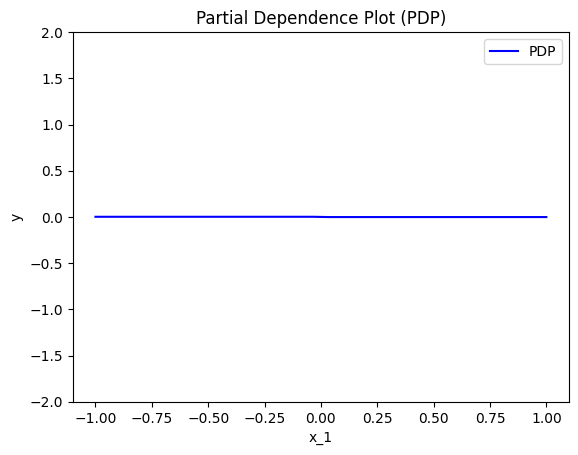

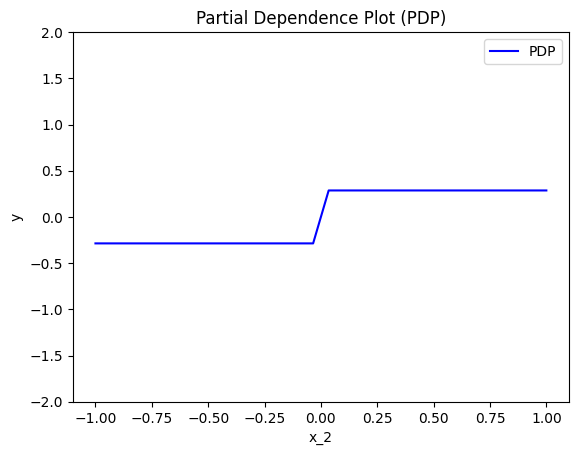

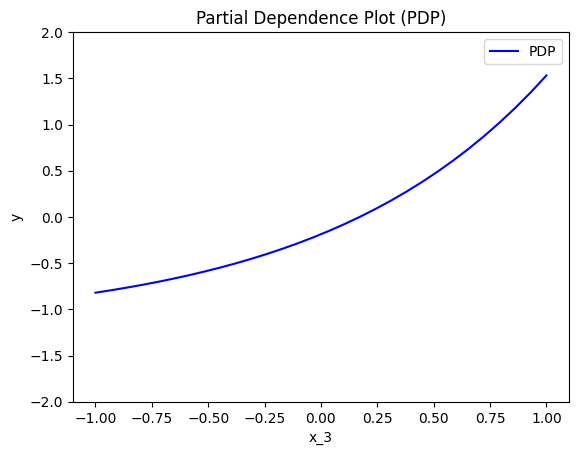

In [7]:
pdp = effector.PDP(x, model.predict, dataset.axis_limits)
pdp.fit(features="all", centering=True)
for feature in [0, 1, 2, 3]:
    pdp.plot(feature=feature, centering=True, y_limits=[-2, 2], heterogeneity=False)

PDP states that:

$x_1$ has a zero average effect on the model output because the symmetric contributions of its positive and negative terms cancel each other out.

$x_2$ has a constant effect close to zero for both $x_2 < 0$ and $x_2 \geq 0$. There is no significant change in $y$ when moving between $x_2^-$ and $x_2^+$, as the average effects cancel out.

$x_3$ has a stepwise effect on the model output:  
- For $x_3 < 0$, the average contribution is $-\frac{4}{15}$.  
- For $x_3 \geq 0$, the average contribution is $+\frac{4}{15}$.  

$x_4$ has an effect of $e^{x_4}$


### Derivations

How PDP leads to these explanations? Are they meaningfull? Let's have some analytical derivations.
If you don't care about the derivations, skip the following three cells and go directly to the coclusions.

For $x_1$:

$$
\begin{align}
PDP(x_1) &\propto \frac{1}{N} \sum_{i=1}^{N} f(x_1, \mathbf{x}^i_{/1}) \\
&\propto \frac{1}{N} \sum_{i=1}^{N} \Big( -x_1^2 \mathbb{1}_{x_2^i < 0 \land x_3^i < 0} 
+ x_1^2 \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0} \\
&\quad -x_1^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0} 
+ x_1^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} + e^{x_4^i} \Big) \\
&\propto \frac{1}{N} \Big( x_1^2 \sum_{i=1}^{N} \big( -\mathbb{1}_{x_2^i < 0 \land x_3^i < 0} 
+ \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0} \big) \\
&\quad + x_1^4 \sum_{i=1}^{N} \big( -\mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0} 
+ \mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} \big) 
+ \sum_{i=1}^{N} e^{x_4^i} \Big) \\
&\approx c
\end{align}
$$


For $x_2$:

$$
PDP(x_2) \propto \frac{1}{N} \sum_{i=1}^N f(\mathbf{x}_{/2}^i, x_2),
$$

Taking the expectation over $x_1, x_3, x_4$, we find:

1. For $x_2 < 0$:

$$
PDP(x_2 < 0) \propto 0.5 \cdot \mathbb{E}[-x_1^2] + 0.5 \cdot \mathbb{E}[x_1^2] \approx 0,
$$


2. For $x_2 \geq 0$:

$$
PDP(x_2 \geq 0) \propto 0.5 \cdot \mathbb{E}[-x_1^4] + 0.5 \cdot \mathbb{E}[x_1^4] \approx 0,
$$


Thus:

$$
PDP(x_2) \approx c.
$$


For $x_3$:

$$
PDP(x_3) \propto \frac{1}{N} \sum_{i=1}^N f(\mathbf{x}_{/3}^i, x_3),
$$

Taking the expectation over $x_1, x_2, x_4$, we find:

1. For $x_3 < 0$:

$$
PDP(x_3 < 0) \propto 0.5 \cdot \mathbb{E}[-x_1^2] + 0.5 \cdot \mathbb{E}[-x_1^4],
$$

$$
PDP(x_3 < 0) \propto -\frac{4}{15}.
$$

2. For $x_3 \geq 0$:

$$
PDP(x_3 \geq 0) \propto 0.5 \cdot \mathbb{E}[x_1^2] + 0.5 \cdot \mathbb{E}[x_1^4],
$$

$$
PDP(x_3 \geq 0) \propto \frac{4}{15}.
$$

Thus, the global PDP for $x_3$ is a step function:

$$
PDP(x_3) = 
\begin{cases} 
-\frac{4}{15} & \text{if } x_3 < 0, \\ 
\frac{4}{15} & \text{if } x_3 \geq 0.
\end{cases}
$$


For $x_4$:

\begin{align}
PDP(x_4) &\propto \frac{1}{N} \sum_{i=1}^{n} f(x_4, x_{/4}^i) \\
&\propto e^{x_4} + c\\
\end{align}

### Conclusions

Are the PDP effects intuitive?

- For $x_1$:  
  The effect is zero. The terms related to $x_1$ are $-x_1^2 \mathbb{1}_{x_3 < 0} + x_1^2 \mathbb{1}_{x_3 \geq 0}$ when $x_2 < 0$, and $-x_1^4 \mathbb{1}_{x_3 < 0} + x_1^4 \mathbb{1}_{x_3 \geq 0}$ when $x_2 \geq 0$. Since $x_2, x_3 \sim \mathcal{U}(-1,1)$, the symmetric distribution of these variables ensures that, on average, the positive and negative contributions of $x_1$ cancel out.

- For $x_2$:  
  The effect is constant and close to zero for both $x_2 < 0$ and $x_2 \geq 0$. The terms involving $x_2$ are $-x_1^2 \mathbb{1}_{x_3 < 0} + x_1^2 \mathbb{1}_{x_3 \geq 0}$ for $x_2 < 0$, and $-x_1^4 \mathbb{1}_{x_3 < 0} + x_1^4 \mathbb{1}_{x_3 \geq 0}$ for $x_2 \geq 0$. These terms cancel on average due to the uniform distribution of $x_1$ and $x_3$. 

- For $x_3$:  
  The effect is stepwise:  
  - For $x_3 < 0$, the terms $-x_1^2 \mathbb{1}_{x_2 < 0} - x_1^4 \mathbb{1}_{x_2 \geq 0}$ contribute an average of $-\frac{4}{15}$.  
  - For $x_3 \geq 0$, the terms $x_1^2 \mathbb{1}_{x_2 < 0} + x_1^4 \mathbb{1}_{x_2 \geq 0}$ contribute an average of $+\frac{4}{15}$.  

- For $x_4$:  
  The effect is $e^{x_4}$, as expected, since the $e^{x_4}$ term is independent of other variables and directly contributes to the output.


In [3]:
def compute_centering_constant(func, start, stop, nof_points):
    x = np.linspace(start, stop, nof_points)
    y = func(x)
    return np.mean(y)

def pdp_ground_truth(feature, xs):
    if feature == 0:  
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:  
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2: 
        ff = lambda x: -4 / 15 * (x < 0) + 4 / 15 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 3:  
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

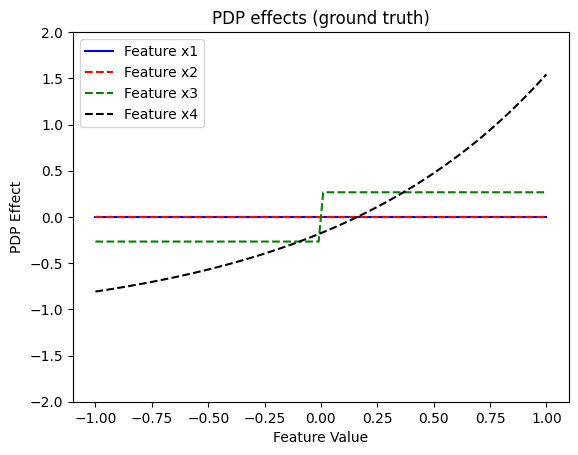

In [8]:
xx = np.linspace(-1, 1, 100)
y_pdp = []
for feature in [0, 1, 2, 3]:
    y_pdp.append(pdp_ground_truth(feature, xx))

plt.figure()
plt.title("PDP effects (ground truth)")
color_pallette = ["blue", "red", "green", "black"]
feature_labels = ["Feature x1", "Feature x2", "Feature x3", "Feature x4"]
for feature in [0, 1, 2, 3]:
    plt.plot(
        xx, 
        y_pdp[feature], 
        color=color_pallette[feature], 
        linestyle="--" if feature !=0 else "-",
        label=feature_labels[feature]
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.xlabel("Feature Value")
plt.ylabel("PDP Effect")
plt.show()

In [5]:
# make a test
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2, 3]:
    y_pdp = pdp.eval(feature=feature, xs=xx, centering=True)
    y_gt = pdp_ground_truth(feature, xx)
    np.testing.assert_allclose(y_pdp, y_gt, atol=1e-1)

## ALE

### Effector

Let's see below the PDP effects for each feature, using `effector`.

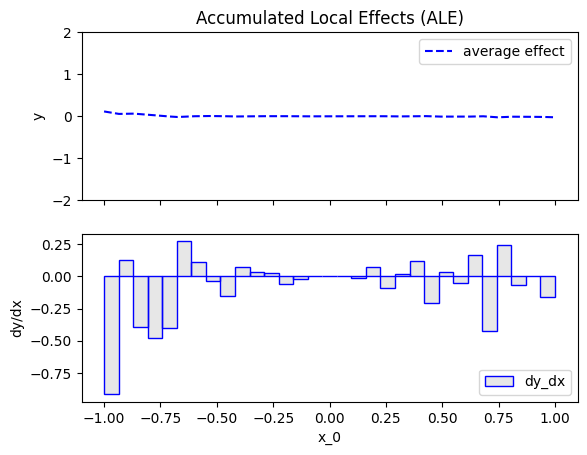

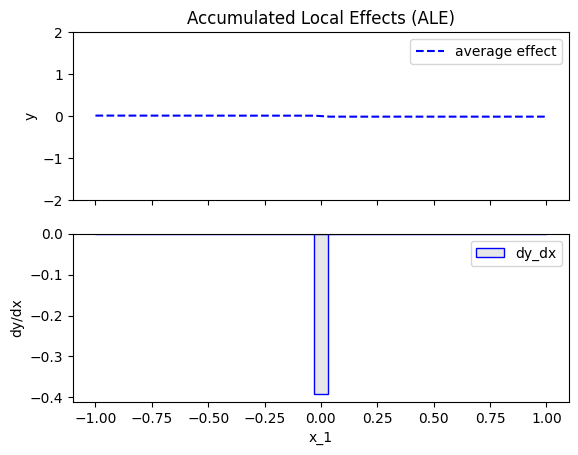

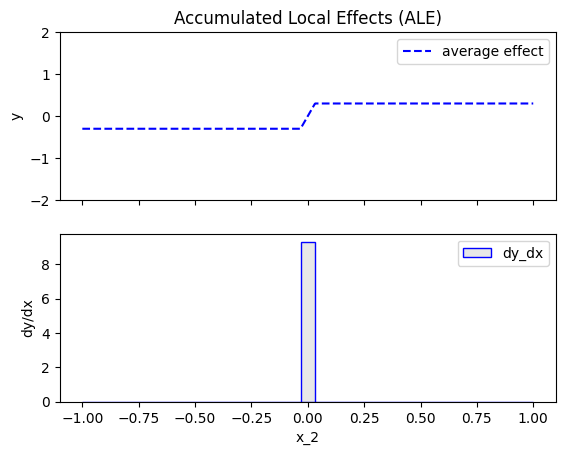

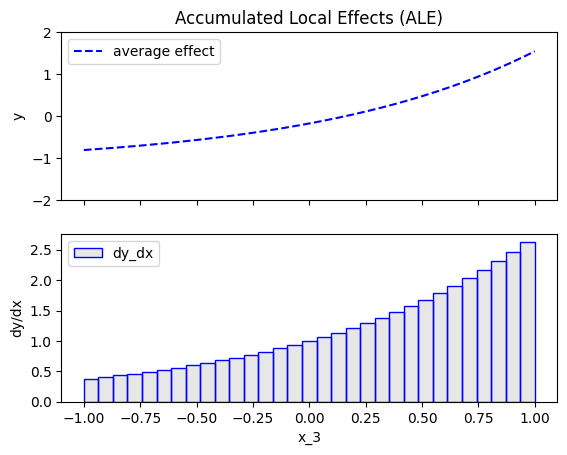

In [11]:
ale = effector.ALE(x, model.predict, axis_limits=dataset.axis_limits)
ale.fit(features="all", centering=True, binning_method=effector.axis_partitioning.Fixed(nof_bins=31))

for feature in [0, 1, 2, 3]:
    ale.plot(feature=feature, centering=True, y_limits=[-2, 2], heterogeneity=False)

ALE states that:



### Derivations

For $x_1$:

$$
\begin{align}
ALE(x_1) &\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ f(z_k, x_2^i, x_3^i, x_4^i) - f(z_{k-1}, x_2^i, x_3^i, x_4^i) \right] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ 
(-z_k^2 \mathbb{1}_{x_2^i < 0 \land x_3^i < 0} + z_k^2 \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0} \\
&\quad - z_k^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0} + z_k^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} + e^{x_4^i}) \\
&\quad - \big( -z_{k-1}^2 \mathbb{1}_{x_2^i < 0 \land x_3^i < 0} + z_{k-1}^2 \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0} \\
&\quad - z_{k-1}^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0} + z_{k-1}^4 \mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} + e^{x_4^i}) \Big] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ 
- z_k^2 (\mathbb{1}_{x_2^i < 0 \land x_3^i < 0} - \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0}) \\
&\quad + z_k^4 (\mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} - \mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0}) \\
&\quad + z_{k-1}^2 (\mathbb{1}_{x_2^i < 0 \land x_3^i < 0} - \mathbb{1}_{x_2^i < 0 \land x_3^i \geq 0}) \\
&\quad - z_{k-1}^4 (\mathbb{1}_{x_2^i \geq 0 \land x_3^i \geq 0} - \mathbb{1}_{x_2^i \geq 0 \land x_3^i < 0}) \Big] \\
&\propto \sum_{k=1}^{k_{x_1}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ 0 \Big] \\
&\approx 0.
\end{align}
$$


For $x_2$:

$$
\begin{align}
ALE(x_2) &\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ f(x^i_1, z_k, x^i_3, x^i_4) - f(x^i_1, z_{k-1}, x^i_3, x^i_4) \right] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ (-x_1^2 \mathbb{1}_{z_k < 0} + x_1^2 \mathbb{1}_{z_k \geq 0} + e^{x_4^i}) \\
&\quad - (-x_1^2 \mathbb{1}_{z_{k-1} < 0} + x_1^2 \mathbb{1}_{z_{k-1} \geq 0} + e^{x_4^i}) \Big] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ -x_1^2 (\mathbb{1}_{z_k < 0} - \mathbb{1}_{z_{k-1} < 0}) 
+ x_1^2 (\mathbb{1}_{z_k \geq 0} - \mathbb{1}_{z_{k-1} \geq 0}) \Big] \\
&\propto \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \Big[ -x_1^2 \underbrace{(\mathbb{1}_{z_k < 0} - \mathbb{1}_{z_{k-1} < 0})}_{\approx 0} 
+ x_1^2 \underbrace{(\mathbb{1}_{z_k \geq 0} - \mathbb{1}_{z_{k-1} \geq 0})}_{\approx 0} \Big] \\
&\approx \sum_{k=1}^{k_{x_2}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} 0 \\
&\approx 0.
\end{align}
$$


For $x_3$:

\begin{align}
ALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ f(x_1^i, x_2^i, z_k, x_4^i) - f(x_1^i, x_2^i, z_{k-1}, x_4^i) \right] \\
&= \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \bigg[ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i < 0} -{x_1^i}^2 \mathbb{1}_{z_k < 0} + {x_1^i}^2 \mathbb{1}_{z_k \geq 0} + {x_1^i}^2 \mathbb{1}_{z_{k-1} < 0} - {x_1^i}^2 \mathbb{1}_{z_{k-1} \geq 0} \\
&\quad + \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i \geq 0} -{x_1^i}^4 \mathbb{1}_{z_k < 0} + {x_1^i}^4 \mathbb{1}_{z_k \geq 0} + {x_1^i}^4 \mathbb{1}_{z_{k-1} < 0} - {x_1^i}^4 \mathbb{1}_{z_{k-1} \geq 0} \bigg]
\end{align}

In the inner expression, if $z_k, z_{k-1}$ are both positive or both negative, then it can be seen that the corresponding terms cancel each other out, thus the contribution to the outer sum is 0. Only when $z_k > 0 > z_{k-1}$ is the inner expression nonzero, and specifically equal to:

\begin{align}
& \frac{1}{| \mathcal{S}_k |} \left[ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i < 0} {x_1^i}^2 + {x_1^i}^2 
+ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i \geq 0} {x_1^i}^4 + {x_1^i}^4 \right] \\
\approx \ & 2 \mathbb{E}[ x_1^2 \mathbb{1}_{x_2 < 0} + x_1^4 \mathbb{1}_{x_2 \geq 0} ] \\
= \ & 2 (\frac{1}{2} \mathbb{E}[x_1^2] + \frac{1}{2} \mathbb{E}[x_1^4]) = \frac{8}{15}
\end{align}

So:
\begin{equation}
ALE(x_3) \propto
\begin{cases}
c & x_3 < 0 \\
c + \frac{8}{15} & x_3 \geq 0
\end{cases}
\end{equation}

For $x_4$:

\begin{align}
ALE(x_4) &\propto \sum_{k=1}^{k_{x_4}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ f(x_i^1, x_i^2, x_i^3, z_k) - f(x_i^1, x_i^2, x_i^3, z_{k-1}) \right] \\
&\propto \sum_{k=1}^{k_{x_4}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ e^{z_k} - e^{z_{k-1}} \right] \\
&\approx e^{x_3}
\end{align}



In [12]:
def compute_centering_constant(func, start, stop, nof_points):
    x = np.linspace(start, stop, nof_points)
    y = func(x)
    return np.mean(y)

def ale_ground_truth(feature, xs):
    if feature == 0:  
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:  
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2: 
        ff = lambda x: -4 / 15 * (x < 0) + 4 / 15 * (x >= 0)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 3:  
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z


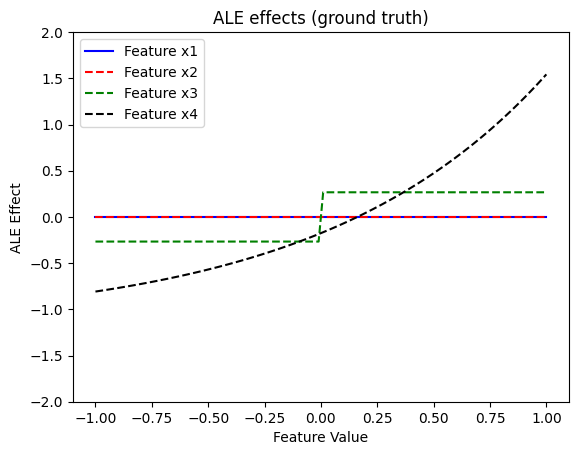

In [17]:
xx = np.linspace(-1, 1, 100)
y_ale = []
for feature in [0, 1, 2, 3]:
    y_ale.append(ale_ground_truth(feature, xx))
    
plt.figure()
plt.title("ALE effects (ground truth)")
color_pallette = ["blue", "red", "green", "black"]
feature_labels = ["Feature x1", "Feature x2", "Feature x3", "Feature x4"]
for feature in [0, 1, 2, 3]:
    plt.plot(
        xx, 
        y_ale[feature], 
        color=color_pallette[feature], 
        linestyle="--" if feature !=0 else "-",
        label=feature_labels[feature]
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.xlabel("Feature Value")
plt.ylabel("ALE Effect")
plt.show()

In [20]:
xx = np.linspace(-1, 1, 100)
for feature in [0, 1, 2, 3]:
    y_ale = ale.eval(feature=feature, xs=xx, centering=True)
    y_gt = ale_ground_truth(feature, xx)
    
    # hack to remove the effect at undefined region
    if feature == 1:
        K = 31
        ind = np.logical_and(xx > -1/K, xx < 1/K)
        y_ale[ind] = 0
        y_gt[ind] = 0
    
    np.testing.assert_allclose(y_ale, y_gt, atol=2e-1)

### Conclusions

Are the ALE effects intuitive?

ALE effects are identical to PDP effects which, as discussed above, can be considered intutive.

## RHALE

### Effector

Let's see below the RHALE effects for each feature, using `effector`.

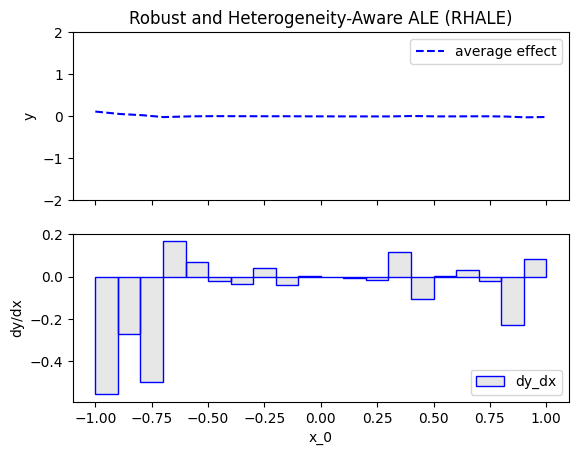

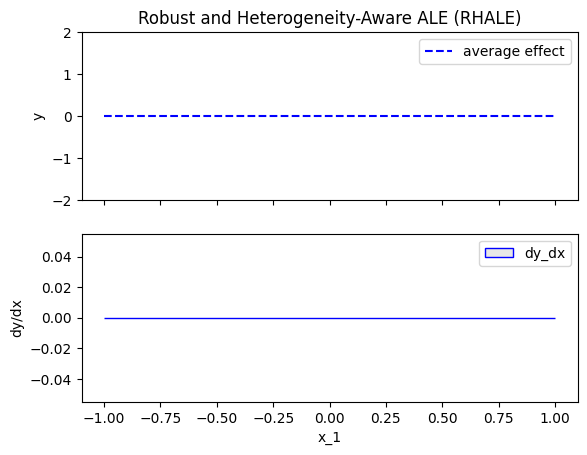

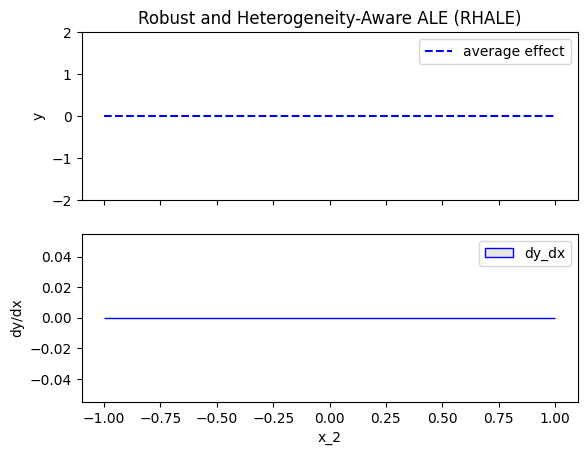

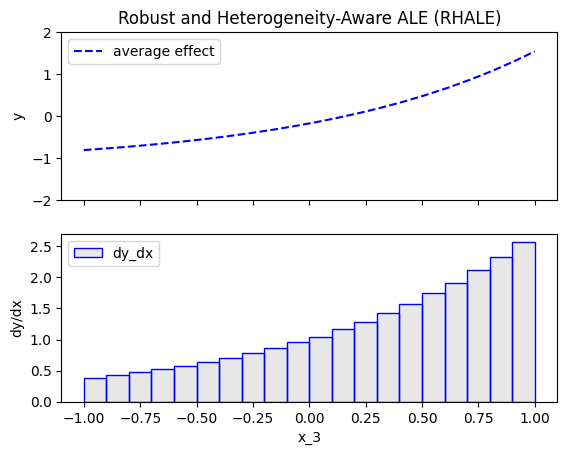

In [25]:
rhale = effector.RHALE(x, model.predict, model.jacobian, axis_limits=dataset.axis_limits)
rhale.fit(features="all", centering=True)

for feature in [0, 1, 2, 3]:
    rhale.plot(feature=feature, centering=True, y_limits=[-2, 2], heterogeneity=False)

RHALE states that:



### Derivations

For $x_1$:

$$
\begin{align}
RHALE(x_1) &= \sum_{k=1}^{k_{x_1}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_1}(x_1, x_{-1}^{(i)}) \right] \\
&= \sum_{k=1}^{k_{x_1}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} 
\left[ - 2 x_1 \mathbb{1}_{x_2^i, x_3^i < 0} + 2 x_1 \mathbb{1}_{x_2^i < 0, x_3^i \geq 0} - 4 {x_1}^3 \mathbb{1}_{x_2^i \geq 0, x_3^i < 0} + 4 {x_1}^3 \mathbb{1}_{x_2^i \geq 0, x_3^i \geq 0} \right] \\
&\approx \sum_{k=1}^{k_{x_1}} (z_k - z_{k-1}) \mathbb{E}_{X_2, X_3} \left[ - 2 x_1 \mathbb{1}_{X_2, X_3 < 0} + 2 x_1 \mathbb{1}_{X_2 < 0, X_3 \geq 0} - 4 {x_1}^3 \mathbb{1}_{X_2 \geq 0, X_3 < 0} + 4 {x_1}^3 \mathbb{1}_{X_2 \geq 0, X_3 \geq 0} \right] \\
&= 0
\end{align}
$$

since the variables are distributed uniformly in $[-1, 1]$.

For $x_2$:

$$
\begin{align}
RHALE(x_2) &= \sum_{k=1}^{k_{x_2}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_2}(x_2, x_{-2}^{(i)}) \right] \\
&\approx 0
\end{align}
$$

For $x_3$:

$$
\begin{align}
RHALE(x_3) &= \sum_{k=1}^{k_{x_3}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_3}(x_3, x_{-3}^{(i)}) \right] \\
&\approx 0
\end{align}
$$

For $x_4$:

$$
\begin{align}
RHALE(x_4) &= \sum_{k=1}^{k_{x_4}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ \frac{\partial f}{\partial x_4}(x_4, x_{-4}^{(i)}) \right] \\
&= \sum_{k=1}^{k_{x_4}} (z_k - z_{k-1}) \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ e^{x_4} \right] \\
&\approx e^{x_4}
\end{align}
$$

For $x_3$:

\begin{align}
ALE(x_3) &\propto \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left[ f(x_1^i, x_2^i, z_k, x_4^i) - f(x_1^i, x_2^i, z_{k-1}, x_4^i) \right] \\
&= \sum_{k=1}^{k_{x_3}} \frac{1}{| \mathcal{S}_k |} \bigg[ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i < 0} -{x_1^i}^2 \mathbb{1}_{z_k < 0} + {x_1^i}^2 \mathbb{1}_{z_k \geq 0} + {x_1^i}^2 \mathbb{1}_{z_{k-1} < 0} - {x_1^i}^2 \mathbb{1}_{z_{k-1} \geq 0} \\
&\quad + \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i \geq 0} -{x_1^i}^4 \mathbb{1}_{z_k < 0} + {x_1^i}^4 \mathbb{1}_{z_k \geq 0} + {x_1^i}^4 \mathbb{1}_{z_{k-1} < 0} - {x_1^i}^4 \mathbb{1}_{z_{k-1} \geq 0} \bigg]
\end{align}

In the inner expression, if $z_k, z_{k-1}$ are both positive or both negative, then it can be seen that the corresponding terms cancel each other out, thus the contribution to the outer sum is 0. Only when $z_k > 0 > z_{k-1}$ is the inner expression nonzero, and specifically equal to:

\begin{align}
& \frac{1}{| \mathcal{S}_k |} \left[ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i < 0} {x_1^i}^2 + {x_1^i}^2 
+ \sum_{i: x^{(i)} \in \mathcal{S}_k, x_2^i \geq 0} {x_1^i}^4 + {x_1^i}^4 \right] \\
\approx \ & 2 \mathbb{E}[ x_1^2 \mathbb{1}_{x_2 < 0} + x_1^4 \mathbb{1}_{x_2 \geq 0} ] \\
= \ & 2 (\frac{1}{2} \mathbb{E}[x_1^2] + \frac{1}{2} \mathbb{E}[x_1^4]) = \frac{8}{15}
\end{align}

So:
\begin{equation}
ALE(x_3) \propto
\begin{cases}
c & x_3 < 0 \\
c + \frac{8}{15} & x_3 \geq 0
\end{cases}
\end{equation}

In [22]:
def rhale_ground_truth(feature, xs):
    if feature == 0:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 1:
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 2:
        K = 31
        ff = lambda x: np.zeros_like(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z
    elif feature == 3:
        ff = lambda x: np.exp(x)
        z = compute_centering_constant(ff, -1, 1, 1000)
        return ff(xs) - z

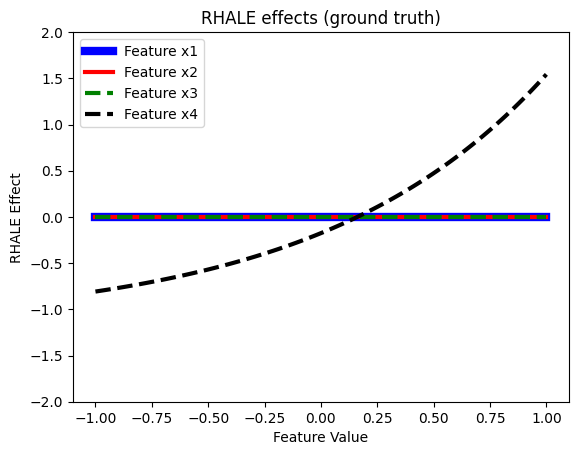

In [26]:
xx = np.linspace(-1, 1, 100)
y_rhale = []
for feature in [0, 1, 2, 3]:
    y_rhale.append(rhale_ground_truth(feature, xx))
    
plt.figure()
plt.title("RHALE effects (ground truth)")
color_pallette = ["blue", "red", "green", "black"]
feature_labels = ["Feature x1", "Feature x2", "Feature x3", "Feature x4"]
for feature in [0, 1, 2, 3]:
    plt.plot(
        xx, 
        y_rhale[feature], 
        color=color_pallette[feature], 
        linestyle="-" if feature in [0,1] else "--",
        linewidth=6 if feature == 0 else 3,
        label=feature_labels[feature]
    )
plt.legend()
plt.xlim([-1.1, 1.1])
plt.ylim([-2, 2])
plt.xlabel("Feature Value")
plt.ylabel("RHALE Effect")
plt.show()



In [27]:
for feature in [0, 1, 2, 3]:
    y_ale = rhale.eval(feature=feature, xs=xx, centering=True)
    y_gt = rhale_ground_truth(feature, xx)
    np.testing.assert_allclose(y_ale, y_gt, atol=1e-2)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0.01

Mismatched elements: 27 / 100 (27%)
Max absolute difference among violations: 0.10882461
Max relative difference among violations: inf
 ACTUAL: array([ 1.088246e-01,  9.760032e-02,  8.637602e-02,  7.515172e-02,
        6.392743e-02,  5.299232e-02,  4.755177e-02,  4.211122e-02,
        3.667067e-02,  3.123012e-02,  2.532642e-02,  1.525433e-02,...
 DESIRED: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,...

### Conclusions

Are the RHALE effects intuitive?

Yes, we could safely say that they are intuitive. All are the same as in the previous methods (which we already discussed), the only exception being $x_3$, for which the RHALE is now flat, instead of having a step at 0 like before. This can be explained, since RHALE plots work with the derivatives and all derivatives with respect to $x_3$ are zero, provided we do not evaluate them at exactly 0, which we probably do not.